In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import tensorflow as tf


2023-06-21 19:37:48.899703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 19:37:49.956683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
datadir = '/mnt/c/Users/jmtan/OneDrive/Documentos/github/Pista2/'
columns = ['center', 'left', 'right', 'steering', 'throttle','reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

center  \
0  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
1  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
2  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
3  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
4  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   

                                                left  \
0  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
1  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
2  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
3  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   
4  C:\Users\jmtan\OneDrive\Documentos\github\Pist...   

                                               right  steering  throttle  \
0  C:\Users\jmtan\OneDrive\Documentos\github\Pist...       0.0       0.0   
1  C:\Users\jmtan\OneDrive\Documentos\github\Pist...       0.0       0.0   
2  C:\Users\jmtan\OneDrive\Documentos\github\Pist...       0.0       0.0   
3  C:\Users\jmtan\OneDrive\Documentos\github\Pist...       0.1       0.0   
4  C:\Users\jmtan\OneDrive\Documentos\github\Pist...       0.3       0.0   

   reverse     speed  
0        0  4.421773  
1        0  4.395093  
2        0  4.359771  
3        0  4.332001  
4        0  4.285356

In [4]:
def path_leaf(path):
    # : This module provides os.path functionality on Windows platforms.
    # : ntpath.split() gives the file name and folder path
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


center                              left  \
0  center_2023_06_21_11_21_22_114.jpg  left_2023_06_21_11_21_22_114.jpg   
1  center_2023_06_21_11_21_22_182.jpg  left_2023_06_21_11_21_22_182.jpg   
2  center_2023_06_21_11_21_22_250.jpg  left_2023_06_21_11_21_22_250.jpg   
3  center_2023_06_21_11_21_22_319.jpg  left_2023_06_21_11_21_22_319.jpg   
4  center_2023_06_21_11_21_22_389.jpg  left_2023_06_21_11_21_22_389.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_06_21_11_21_22_114.jpg       0.0       0.0        0  4.421773  
1  right_2023_06_21_11_21_22_182.jpg       0.0       0.0        0  4.395093  
2  right_2023_06_21_11_21_22_250.jpg       0.0       0.0        0  4.359771  
3  right_2023_06_21_11_21_22_319.jpg       0.1       0.0        0  4.332001  
4  right_2023_06_21_11_21_22_389.jpg       0.3       0.0        0  4.285356

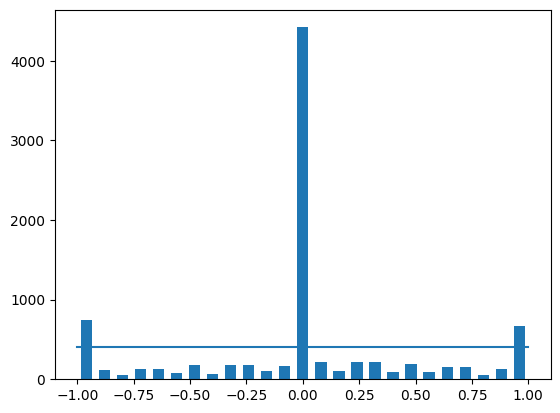

In [5]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


total data: 8826
removed: 4626
remaining: 4200


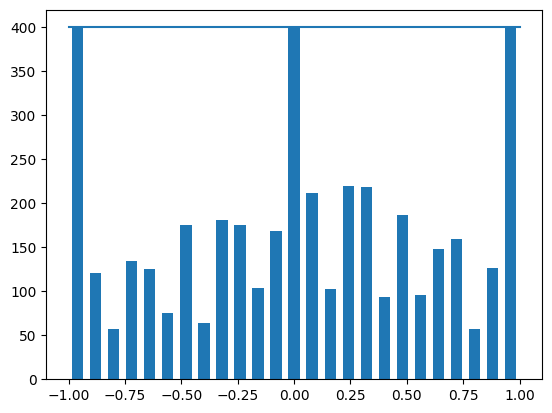

In [6]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


In [7]:
print(data.iloc[1])

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1],indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(datadir + '/IMG', data)


center      center_2023_06_21_11_21_22_389.jpg
left          left_2023_06_21_11_21_22_389.jpg
right        right_2023_06_21_11_21_22_389.jpg
steering                                   0.3
throttle                                   0.0
reverse                                      0
speed                                 4.285356
Name: 4, dtype: object


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples:{}'.format(len(X_train), len(X_valid)))


Training Samples: 10080
Valid Samples:2520


Text(0.5, 1.0, 'Validation set')

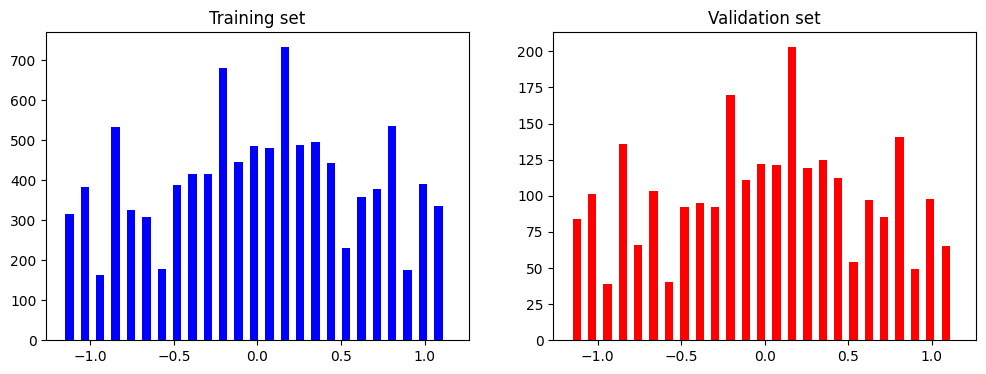

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

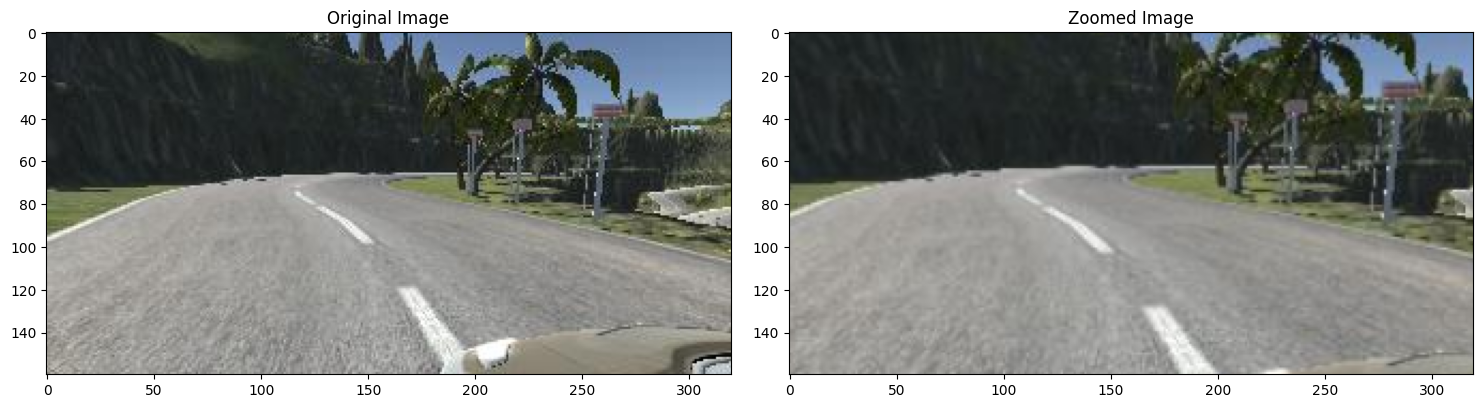

In [10]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

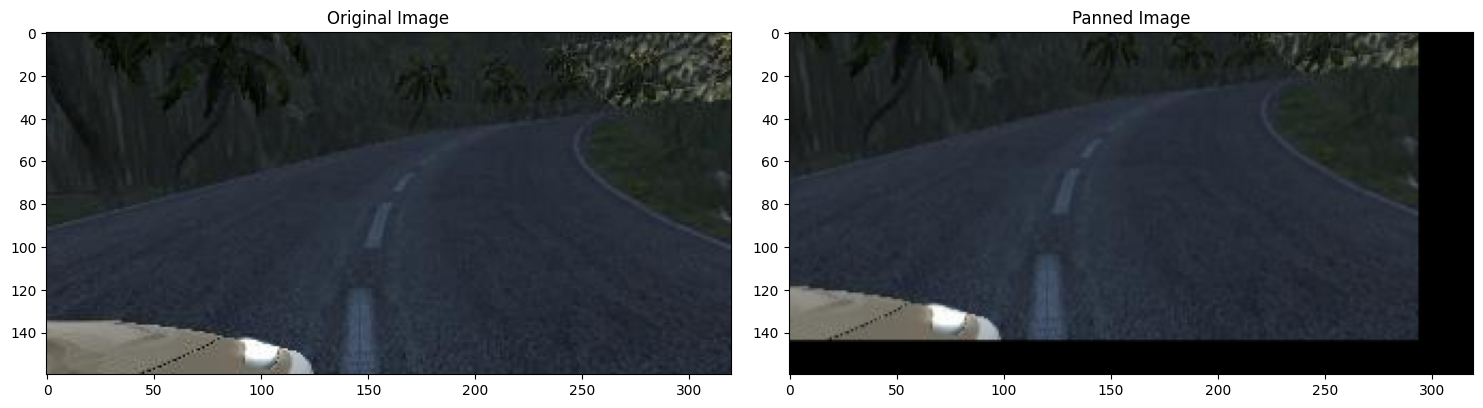

In [11]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y":(-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

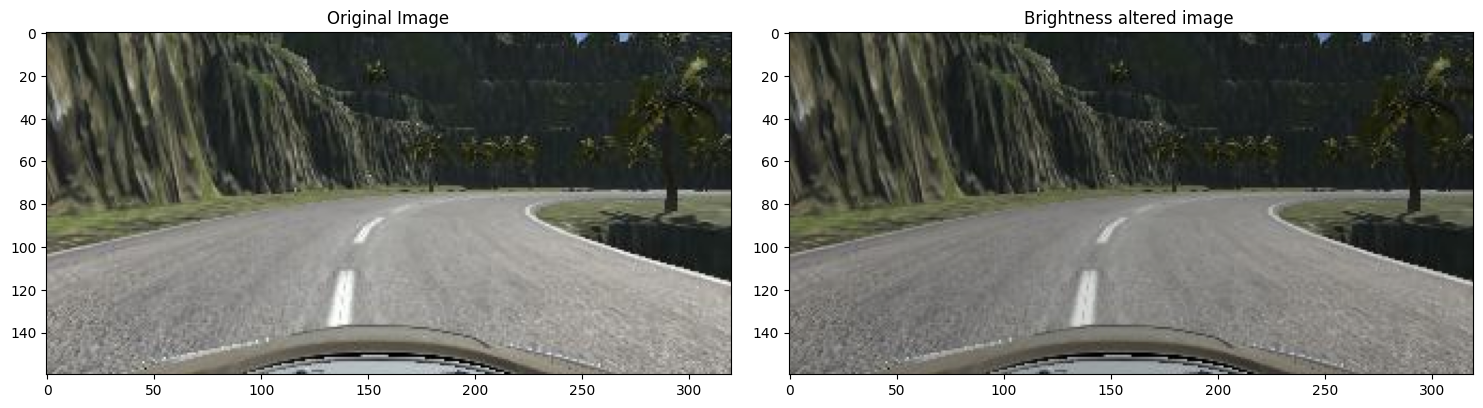

In [12]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.6')

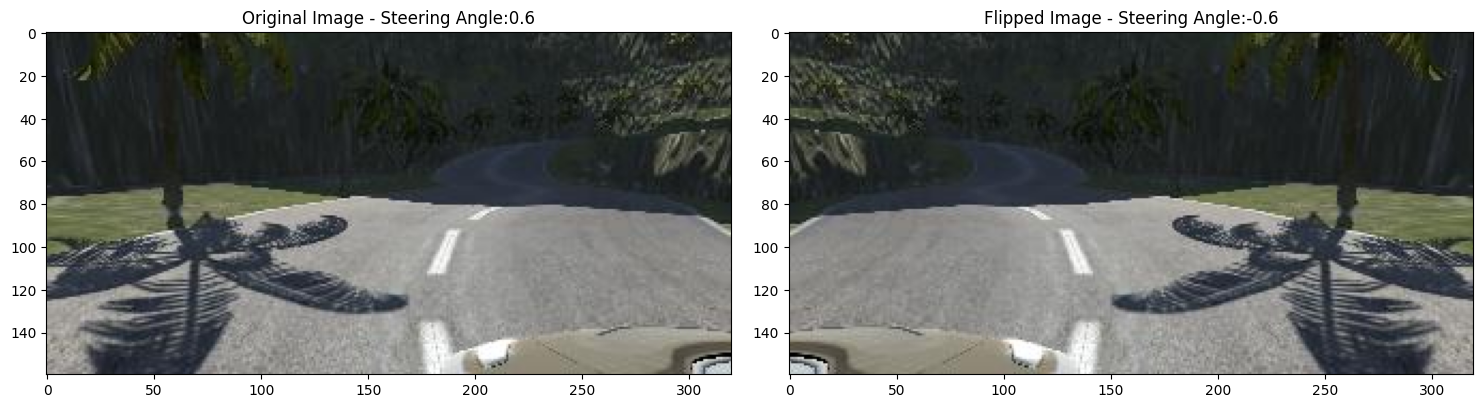

In [13]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' +   str(flipped_steering_angle))

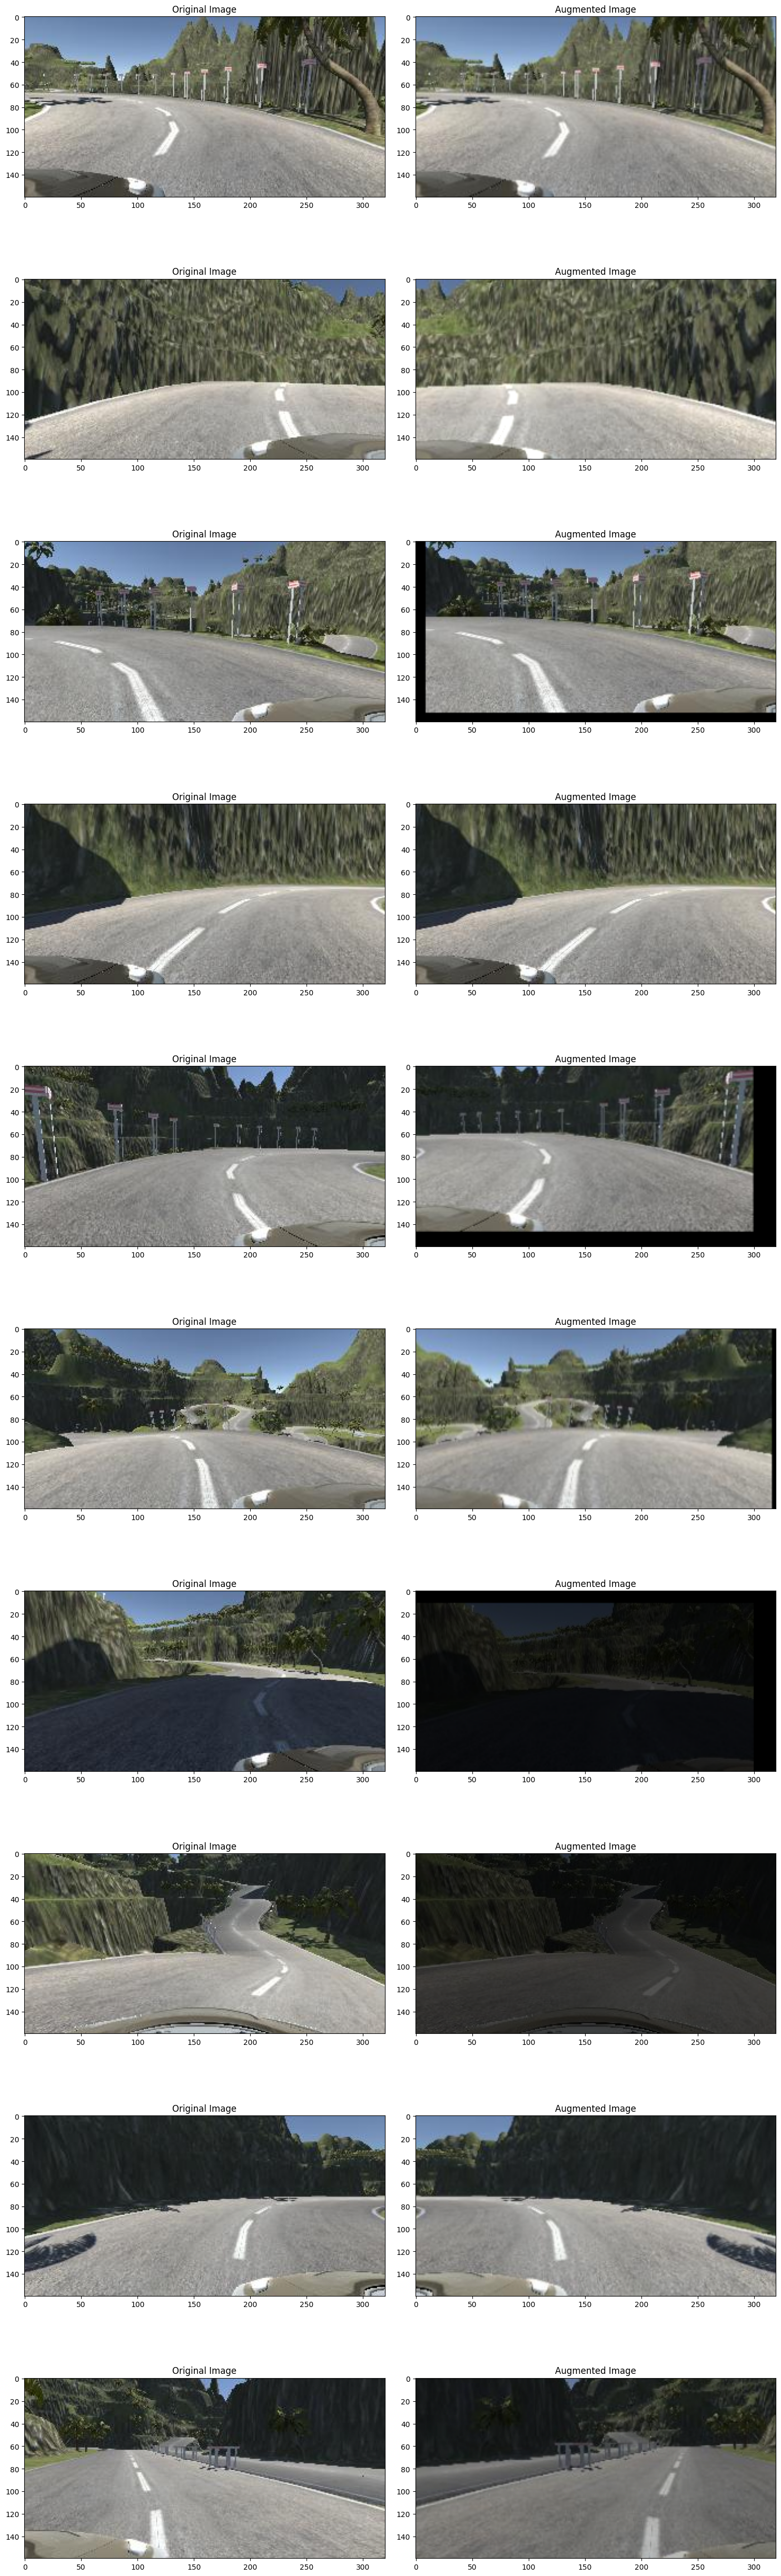

In [14]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
 
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image,random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

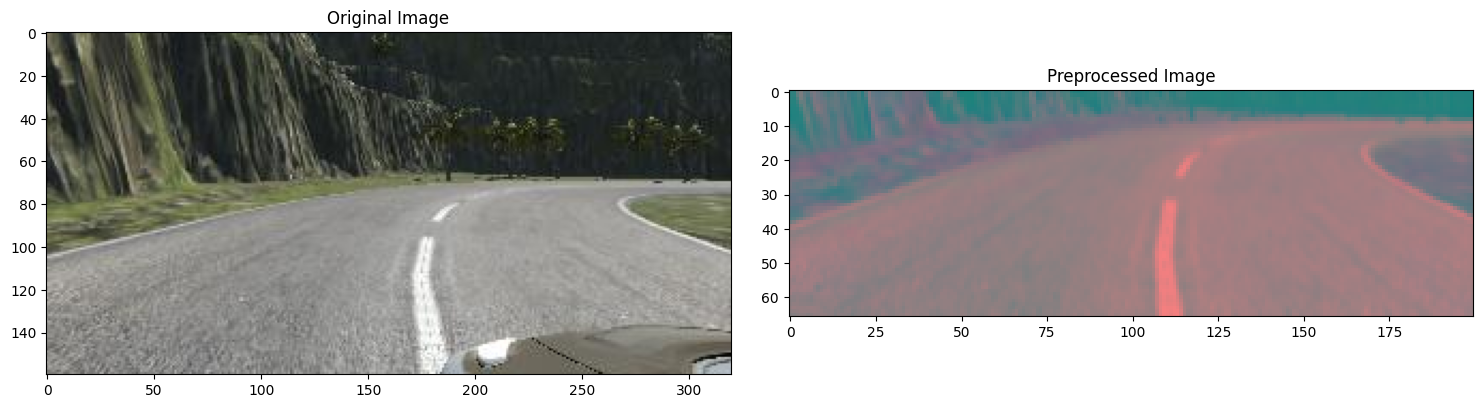

In [15]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [16]:
def batch_generator(image_paths, steering_ang, batch_size,istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            if istraining:
                im, steering = random_augment(image_paths[random_index],steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

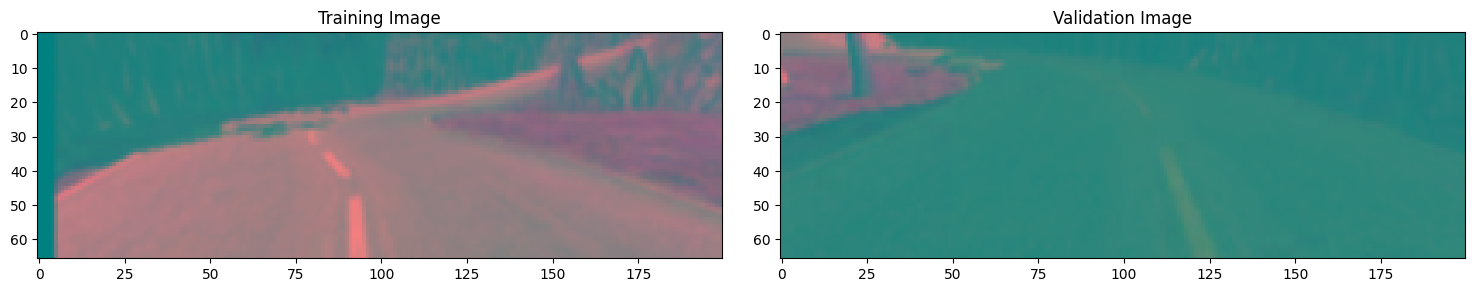

In [17]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train,1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid,1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [18]:
def nvidia_model():
  model = Sequential()
  model.add(tf.keras.layers.Conv2D(24,(5,5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(tf.keras.layers.Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='elu'))
  
  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [20]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
history = model.fit(batch_generator(X_train, y_train,100, 1),
                    steps_per_epoch=300, 
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle = 1)


300/300 [==============================] - 401s 1s/step - loss: 0.1828 - val_loss: 0.1617
Epoch 3/10
300/300 [==============================] - 385s 1s/step - loss: 0.1742 - val_loss: 0.1926
Epoch 4/10
300/300 [==============================] - 397s 1s/step - loss: 0.1738 - val_loss: 0.1508
Epoch 5/10
300/300 [==============================] - 380s 1s/step - loss: 0.1672 - val_loss: 0.1464
Epoch 6/10
300/300 [==============================] - 378s 1s/step - loss: 0.1669 - val_loss: 0.1514
Epoch 7/10
300/300 [==============================] - 394s 1s/step - loss: 0.1618 - val_loss: 0.1530
Epoch 8/10
300/300 [==============================] - 406s 1s/step - loss: 0.1564 - val_loss: 0.1388
Epoch 9/10
300/300 [==============================] - 406s 1s/step - loss: 0.1543 - val_loss: 0.1369
Epoch 10/10
300/300 [==============================] - 396s 1s/step - loss: 0.1458 - val_loss: 0.1268


In [21]:
model.save('modelPista2.h5')


Text(0.5, 0, 'Epoch')

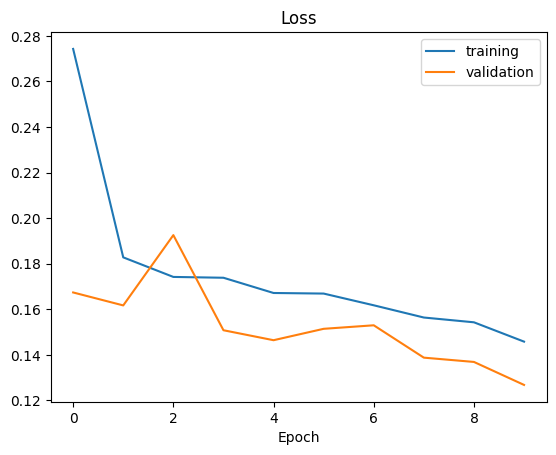

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')